In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import os
from dotenv import load_dotenv


In [2]:
load_dotenv()
os.environ.get('TRAINING_DIRECTORY')

# Set the path to the folders containing the images
# train_dir = './training_data/'
train_dir = os.environ.get('TRAINING_DIRECTORY')

# Define the image size
img_height = 1024
img_width = 1024

# Define the batch size
batch_size = 32


In [3]:
# Rename all images so to a format of XXXX.format (with leading 0s if needed) so that they will be read in the right order
img_dir = f'{train_dir}/mini-healthy'
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    file_name_parts = img_file.split('.')
    file_name = file_name_parts[0]
    new_file_name = f"{int(file_name):04d}.{file_name_parts[1]}"
    os.rename(os.path.join(img_dir, img_file), os.path.join(img_dir, new_file_name))

img_dir = f'{train_dir}/mini-infected'
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    file_name_parts = img_file.split('.')
    file_name = file_name_parts[0]
    new_file_name = f"{int(file_name):04d}.{file_name_parts[1]}"
    os.rename(os.path.join(img_dir, img_file),
              os.path.join(img_dir, new_file_name))


In [3]:
# Read in the images and resize them
classes = ['healthy', 'infected']
images = []
labels = []
img_paths = []
img_dir = f'{train_dir}/mini-healthy'
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(0)
    img_paths.append(path)

img_dir = f'{train_dir}/mini-infected'
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(1)
    img_paths.append(path)

# Convert the data and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
img_paths = np.array(img_paths)


In [4]:
# Get the first y-pixel value where at least 1/64 of the pixels are masked
def get_first_and_last_cucumber_pixel(image):
    masked_img = (image[..., 2] < 150)

    first_cucumber_pixel_y = None
    last_cucumber_pixel_y = None
    threshold = img_width / 64
    for i in range(masked_img.shape[0]):
        if np.sum(masked_img[i, :]) > threshold:
            first_cucumber_pixel_y = i
            j = first_cucumber_pixel_y
            for j in range(i, masked_img.shape[0]):
                if np.sum(masked_img[j, :]) <= threshold:
                    last_cucumber_pixel_y = j
                    break
            break

    first_cucumber_pixel_x = None
    last_cucumber_pixel_x = None
    threshold = img_width / 64
    for i in range(masked_img.shape[1]):
        if np.sum(masked_img[:, i]) > threshold:
            first_cucumber_pixel_x = i
            j = first_cucumber_pixel_x
            for j in range(i, masked_img.shape[0]):
                if np.sum(masked_img[:, j]) <= threshold:
                    last_cucumber_pixel_x = j
                    break
            break

    return ((first_cucumber_pixel_x, first_cucumber_pixel_y), (last_cucumber_pixel_x, last_cucumber_pixel_y))


# Create the DataFrame
df_records = []
for i in range(images.shape[0]):
    ((first_x, first_y), (last_x, last_y)
     ) = get_first_and_last_cucumber_pixel(images[i])
    df_records.append(
        {'idx': i, 'label': classes[labels[i]], 'first_cucumber_pixel_y': first_y, 'last_cucumber_pixel_y': last_y, 'first_cucumber_pixel_x': first_x, 'last_cucumber_pixel_x': last_x, 'cucumber_height': last_x - (first_x)})

df = pd.DataFrame(df_records)

print(df)


     idx     label  first_cucumber_pixel_y  last_cucumber_pixel_y  \
0      0   healthy                     332                    573   
1      1   healthy                     330                    565   
2      2   healthy                     326                    609   
3      3   healthy                     351                    571   
4      4   healthy                     324                    558   
..   ...       ...                     ...                    ...   
302  302  infected                     311                    644   
303  303  infected                     311                    559   
304  304  infected                     331                    582   
305  305  infected                     310                    581   
306  306  infected                     348                    637   

     first_cucumber_pixel_x  last_cucumber_pixel_x  cucumber_height  
0                       166                    848              682  
1                       152    

In [7]:
df_rows = df.iloc
i = 0
img_path_indices_to_keep = []
while i < (images.shape[0]):
    j = 0
    while (i + j + 1 < images.shape[0]) and (df_rows[i + j]['first_cucumber_pixel_y']) < df_rows[i + j + 1]['first_cucumber_pixel_y']:
        j += 1
    idx_to_keep = i + int(j/2)
    img_path_indices_to_keep.append(idx_to_keep)
    i = i + j + 1

img_paths_to_keep = img_paths[img_path_indices_to_keep]
img_paths_to_remove = [
    elem for elem in img_paths if elem not in img_paths_to_keep]


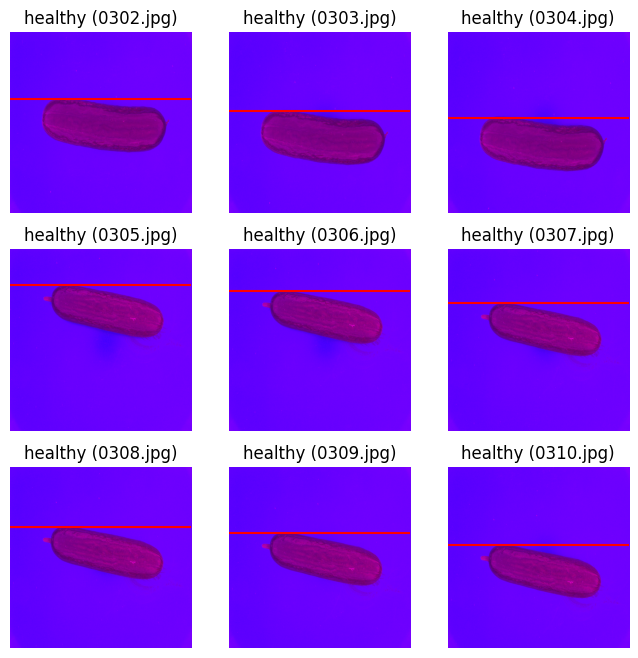

In [11]:
# Some final validation - execute until here before removing

# print(len(img_paths_to_keep))
# print(len(img_paths_to_remove))
# print('--- TO KEEP ---')
# print(img_paths_to_keep[:10])
# print('--- TO REMOVE ---')
# print(np.array(img_paths_to_remove)[:10])

# Plot some random images with their label and a line for the first "cucumber pixel" detected
plt.figure(figsize=(8, 8))
rand = random.randint(0, images.shape[0] - 10)
for i in range(9):
    # rand_idx = random.randint(0, images.shape[0] - 1)
    rand_idx = rand + i
    ax = plt.subplot(3, 3, i + 1)
    plt.axhline(y=df.iloc[rand_idx]
                ['first_cucumber_pixel_y'], color='r', linestyle='-')
    plt.imshow(images[rand_idx])
    path = img_paths[rand_idx].split(os.sep)[-1]
    plt.title(f'{classes[labels[rand_idx]]} ({path})')
    plt.axis('off')


In [12]:
# !!! DANGEROUS: Fully remove the images from the OS
# for img_path in img_paths_to_remove:
#     if os.path.exists(img_path):
#         os.remove(img_path)

In [13]:
# Rename them with 0 based index
img_dir = f'{train_dir}/mini-healthy'
for (idx, img_file) in enumerate(os.listdir(img_dir)):
    path = os.path.join(img_dir, img_file)
    file_name_parts = img_file.split('.')
    file_name = file_name_parts[0]
    new_file_name = f"{int(idx):04d}.{file_name_parts[1]}"
    os.rename(os.path.join(img_dir, img_file),
              os.path.join(img_dir, new_file_name))

img_dir = f'{train_dir}/mini-infected'
for (idx, img_file) in enumerate(os.listdir(img_dir)):
    path = os.path.join(img_dir, img_file)
    file_name_parts = img_file.split('.')
    file_name = file_name_parts[0]
    new_file_name = f"{int(idx):04d}.{file_name_parts[1]}"
    os.rename(os.path.join(img_dir, img_file),
              os.path.join(img_dir, new_file_name))


In [6]:
img_paths[df[df['first_cucumber_pixel_y'] < 2]['idx']]

# !!! DANGEROUS: Fully remove the images from the OS

# for img_path in img_paths[df[df['first_cucumber_pixel_y'] < 2]['idx']]:
#     if os.path.exists(img_path):
#         os.remove(img_path)
